In [1]:
import json
import os
os.environ['PATH_TO_ENV'] = "~/projects/chatsky-llm-autoconfig/.env"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dialogue2graph.pipelines.models import ModelsAPI
models = ModelsAPI()

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


### D2G Algo pipeline

In [4]:
from dialogue2graph.pipelines.d2g_algo.pipeline import Pipeline
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline(filling_llm, formatting_llm, sim_model)

INFO:datasets:PyTorch version 2.6.0 available.
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/models.py:40: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(model=model_name, temperature=parameter)
/data/home/peshkichev/projects/chatsky-llm-autoconfig/dialogue2graph/pipelines/models.py:42: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import 

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


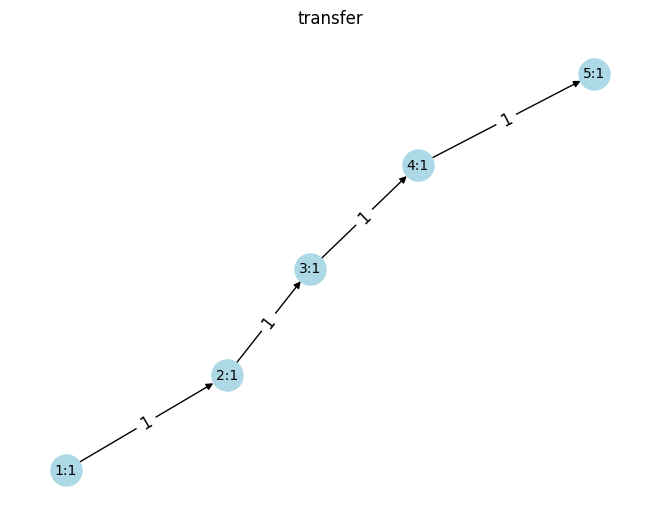

In [5]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

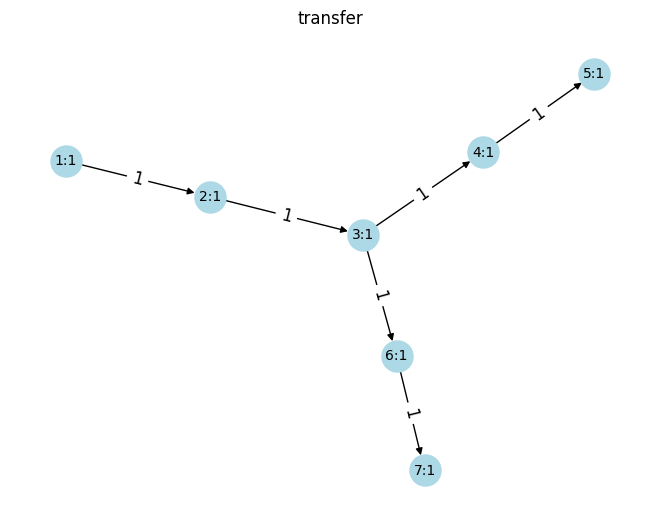

In [6]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

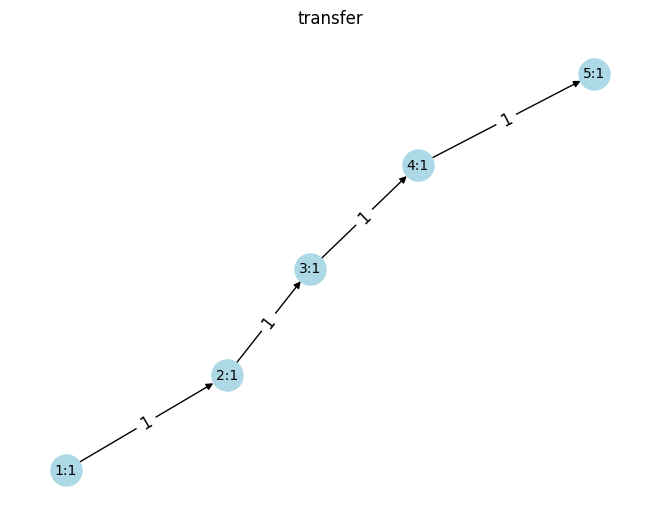

In [7]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

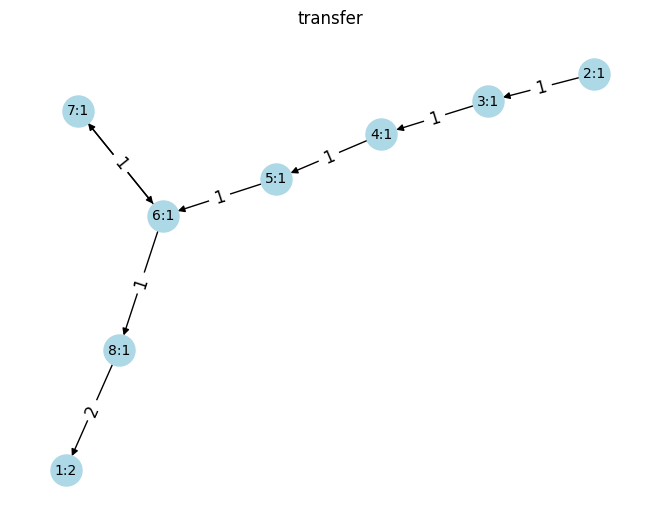

In [8]:
with open('transfer.json') as f:
    data = json.load(f)
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

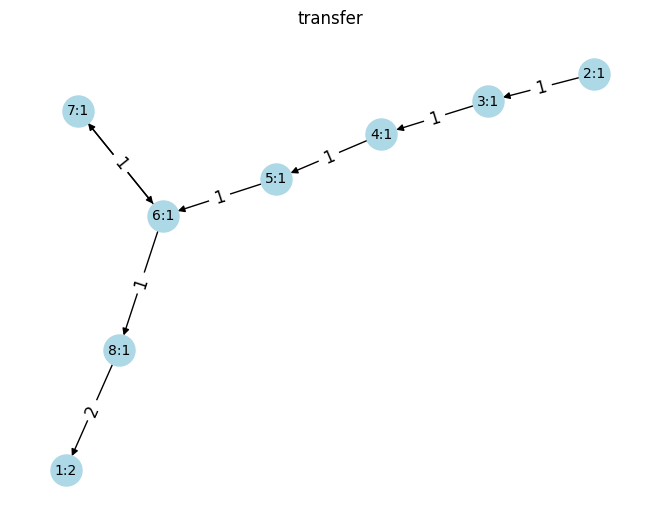

In [9]:
graph = pipeline.invoke("transfer.json")
graph.visualise_short("transfer")

### D2G LLM pipeline

In [11]:
from dialogue2graph.pipelines.d2g_llm.pipeline import Pipeline
grouping_llm = models("llm", name="chatgpt-4o-latest", temp=0)
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline(grouping_llm, filling_llm, formatting_llm, sim_model)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


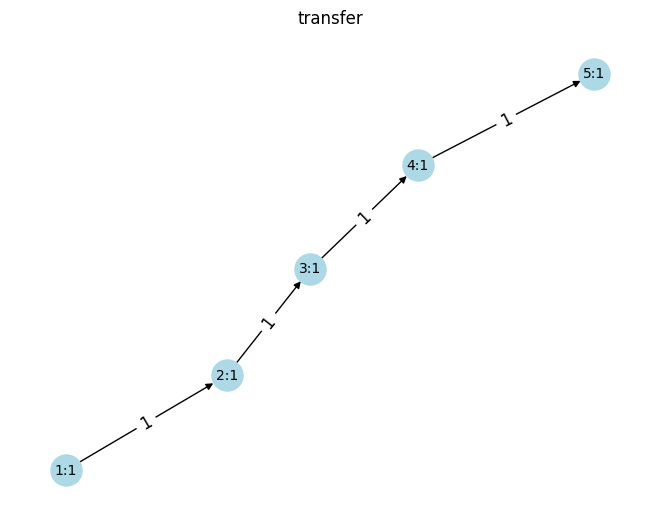

In [12]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


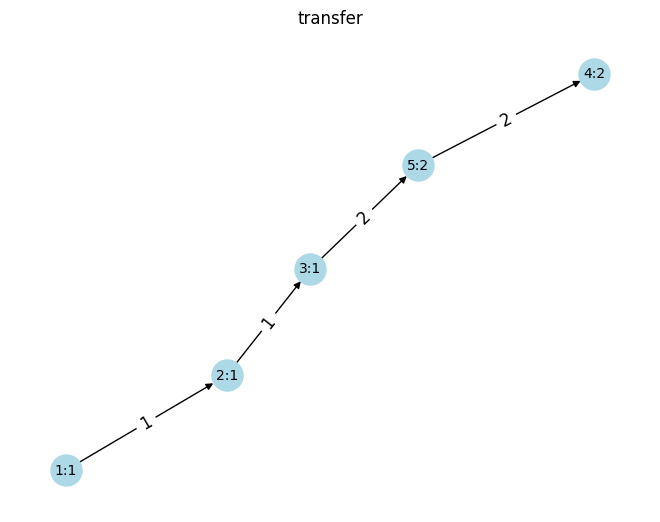

In [13]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


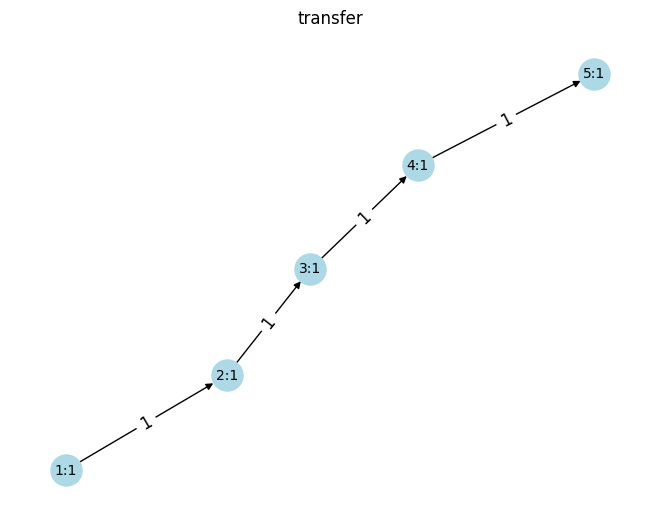

In [14]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


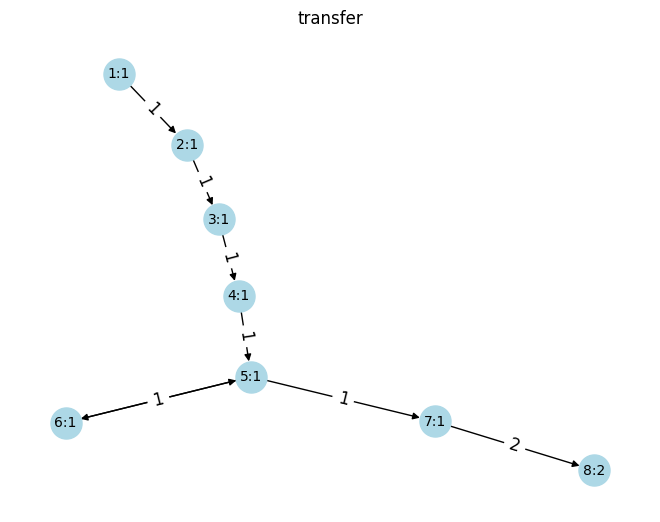

In [15]:
with open('transfer.json') as f:
    data = json.load(f)
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


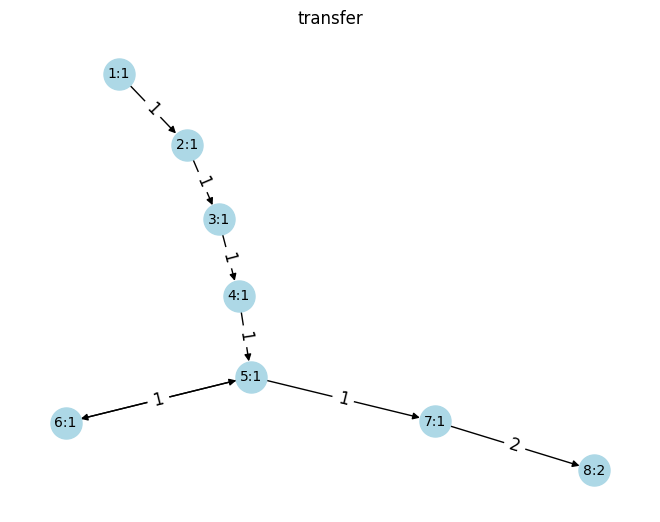

In [16]:
graph = pipeline.invoke("transfer.json")
graph.visualise_short("transfer")

### D2G LLM extender

In [17]:
from dialogue2graph.pipelines.d2g_extender.pipeline import Pipeline
extending_llm = models("llm", name="chatgpt-4o-latest", temp=0)
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline(extending_llm, filling_llm, formatting_llm, sim_model)

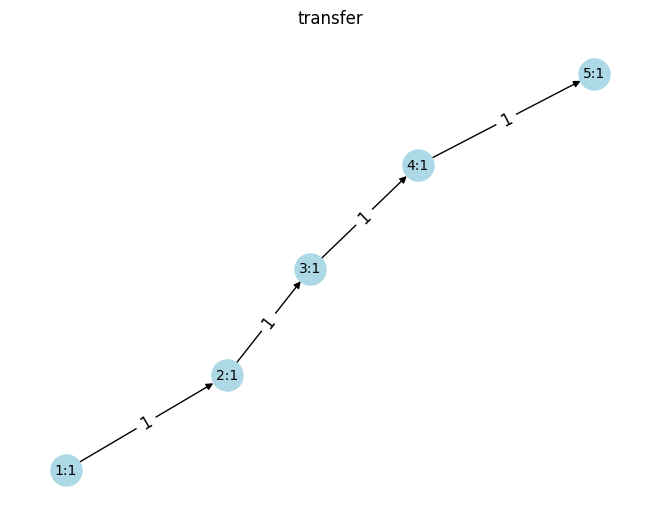

In [18]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


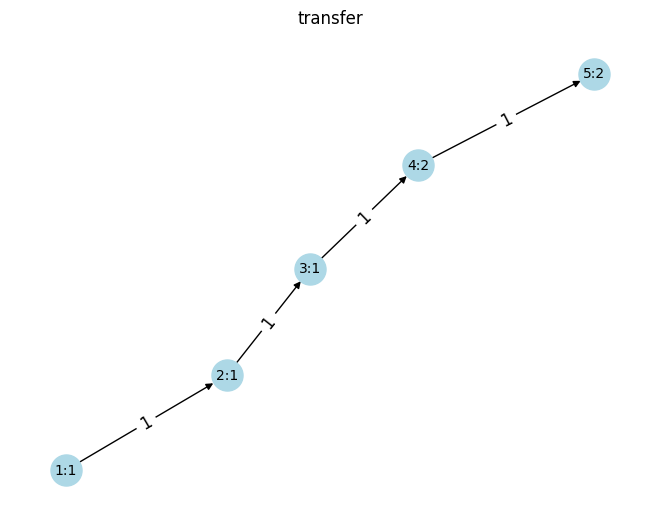

In [19]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

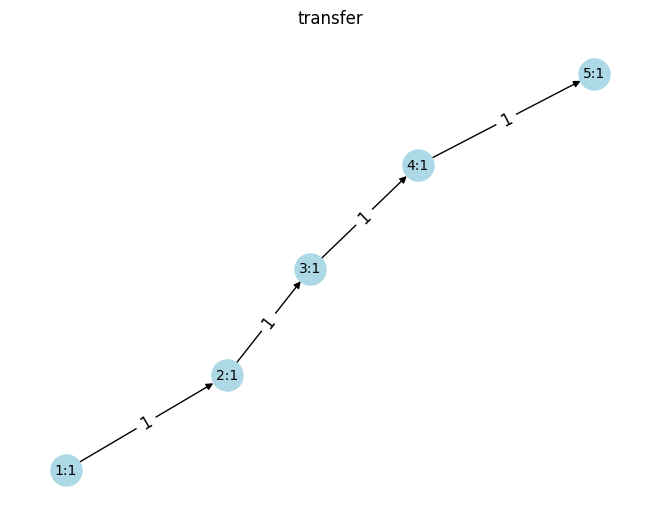

In [20]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


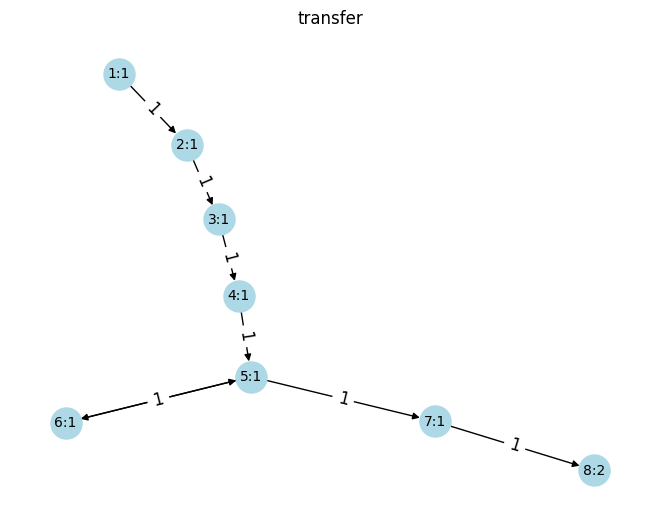

In [21]:
with open('transfer.json') as f:
    data = json.load(f)
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


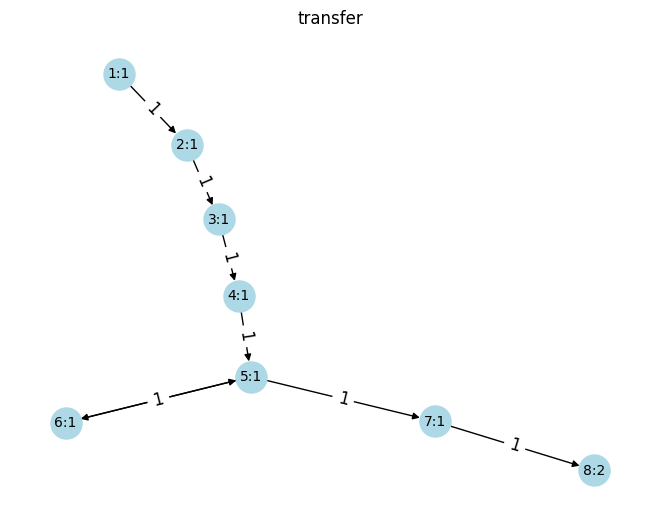

In [22]:
graph = pipeline.invoke("transfer.json")
graph.visualise_short("transfer")

In [24]:
graph.graph_dict['nodes']

[{'id': 1,
  'label': '',
  'is_start': True,
  'utterances': ['Hey there! How can I help you today?']},
 {'id': 2,
  'label': '',
  'is_start': False,
  'utterances': ['Sure! I can help with that. When is your flight, and where are you departing from?']},
 {'id': 3,
  'label': '',
  'is_start': False,
  'utterances': ['Got it. Where should the driver pick you up?']},
 {'id': 4,
  'label': '',
  'is_start': False,
  'utterances': ['Thanks! How many passengers will be traveling?']},
 {'id': 5,
  'label': '',
  'is_start': False,
  'utterances': ['Alright! Do you have any preference for the type of vehicle? We have sedans, SUVs, and vans available.']},
 {'id': 6,
  'label': '',
  'is_start': False,
  'utterances': ['Of course! What type of vehicle would you prefer instead?']},
 {'id': 7,
  'label': '',
  'is_start': False,
  'utterances': ['All set! Your driver will arrive on time. Let me know if you need anything else.']},
 {'id': 8,
  'label': '',
  'is_start': False,
  'utterances': [